#Health Care Predictions

##Neural Network (MLP)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/2022-23 financial and utilization report.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [20]:

#Set target and drop features
target = "NET_TOT"
drop_cols = ["index", "NET_TOT", "BEG_DATE", "END_DATE", "TEACH_RURL"]
drop_cols = [c for c in drop_cols if c in df.columns]  # safe drop

X = df.drop(columns=drop_cols)
y = df[target]


#Function for creating the pipeline that we will call from each fold of the cross validation
def make_preprocess(X_sample):
    num_cols = X_sample.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X_sample.select_dtypes(include=["object"]).columns

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols)
        ]
    )
    return pre, num_cols, cat_cols

#Build the neural network with 128, 64, and 32 input layers with a relu function(Best for linear) (max(0, x)).
def build_model(input_dim: int):
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)   # regression → linear output
    ])
    model.compile(      #Here we calculate loss using mean squared error and find mae for metrics
        optimizer="adam", #This allows us to find the average error from our prediction
        loss="mse",
        metrics=["mae"]
    )
    return model

#Instantiate the 10 k-fold for cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=67)

cv_mse = []
cv_mae = []

fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    #Fresh preprocessor for this fold
    preprocess, num_cols, cat_cols = make_preprocess(X_tr)
    preprocess.fit(X_tr)

    X_tr_nn = preprocess.transform(X_tr)
    X_val_nn = preprocess.transform(X_val)

    # to dense because Keras neural network only accepts dense arrays type
    if hasattr(X_tr_nn, "todense"):
        X_tr_nn = np.array(X_tr_nn.todense())
        X_val_nn = np.array(X_val_nn.todense())
    else:
        X_tr_nn = np.array(X_tr_nn)
        X_val_nn = np.array(X_val_nn)

    #Fresh model for this fold
    model_fold = build_model(X_tr_nn.shape[1])

    #Train the data (using fewer epochs for CV so it doesn’t take forever)
    model_fold.fit(
        X_tr_nn, y_tr,
        validation_data=(X_val_nn, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    #Evaluate each fold and add to the array of validation mse / mae 's
    val_mse, val_mae = model_fold.evaluate(X_val_nn, y_val, verbose=0)
    print(f"Fold {fold} MSE: {val_mse:.2f}, MAE: {val_mae:.2f}")

    cv_mse.append(val_mse)
    cv_mae.append(val_mae)

    fold += 1

print("\n===== Cross-validation summary (10-fold) =====")
print(f"Mean MSE: {np.mean(cv_mse):.2f}   ± {np.std(cv_mse):.2f}")
print(f"Mean MAE: {np.mean(cv_mae):.2f}   ± {np.std(cv_mae):.2f}")


#Make the final train test spli
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=67
)

#Create a fresh preprocessor for the final model
preprocess_final, num_cols_final, cat_cols_final = make_preprocess(X_train)
preprocess_final.fit(X_train)

X_train_nn = preprocess_final.transform(X_train)
X_test_nn = preprocess_final.transform(X_test)

if hasattr(X_train_nn, "todense"):
    X_train_nn = np.array(X_train_nn.todense())
    X_test_nn = np.array(X_test_nn.todense())
else:
    X_train_nn = np.array(X_train_nn)
    X_test_nn = np.array(X_test_nn)

#Build the final model according for the test set
final_model = build_model(X_train_nn.shape[1])
final_model.summary()

history = final_model.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1
)

#Evaluate data on the test set and find metrics
test_mse, test_mae = final_model.evaluate(X_test_nn, y_test, verbose=0)

print("\n===== Final test performance on held-out set =====")
print("Test MSE:", test_mse)
print("Test MAE:", test_mae)



# Get model predictions
y_pred = final_model.predict(X_test_nn).flatten()

# Compute R-squared
r2 = r2_score(y_test, y_pred)

print("R-squared:", r2)



===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 MSE: 3317083773337600.00, MAE: 33124964.00

===== Fold 2 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 MSE: 3388198768082944.00, MAE: 34551928.00

===== Fold 3 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 MSE: 2640799833522176.00, MAE: 29544722.00

===== Fold 4 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 MSE: 2793977963085824.00, MAE: 32226812.00

===== Fold 5 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 MSE: 3794509116735488.00, MAE: 34192632.00

===== Fold 6 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 MSE: 2764076132335616.00, MAE: 29454558.00

===== Fold 7 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 MSE: 2409795822813184.00, MAE: 30011166.00

===== Fold 8 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 MSE: 3120692098760704.00, MAE: 31440778.00

===== Fold 9 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 MSE: 4336204887621632.00, MAE: 36297952.00

===== Fold 10 =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 MSE: 2298034331320320.00, MAE: 29565554.00

===== Cross-validation summary (5-fold) =====
Mean MSE: 3086337272761549.00   ± 606315153905827.50
Mean MAE: 32041106.60   ± 2319371.37


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_111 (Dense)               │ (None, 128)            │       336,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,881 (1.32 MB)

 Trainable params: 346,881 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 38262579444842496.0000 - mae: 92495760.0000 - val_loss: 37104231060078592.0000 - val_mae: 94874288.0000
Epoch 2/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 32028490249273344.0000 - mae: 90359336.0000 - val_loss: 37102096461332480.0000 - val_mae: 94871320.0000
Epoch 3/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 25135649707261952.0000 - mae: 83559880.0000 - val_loss: 37089834329702400.0000 - val_mae: 94854432.0000
Epoch 4/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 34515424490029056.0000 - mae: 92353880.0000 - val_loss: 37051029300183040.0000 - val_mae: 94801936.0000
Epoch 5/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 29683356501278720.0000 - mae: 87424424.0000 - val_loss: 36952975196815360.0000 - val_mae: 94672624.0000
Epoch 6/40
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 26034105325977600.0000 - mae: 83457864.0000 - val_loss: 36765538529050624.0000 - val_mae: 94426632.0000
Epoch 7/40
71/71 ━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


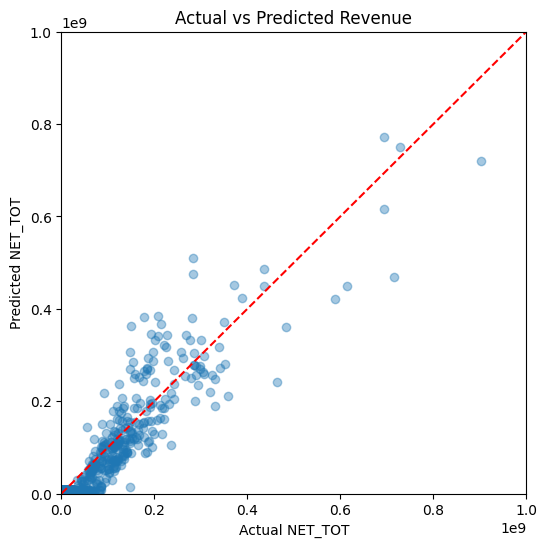

In [18]:
import matplotlib.pyplot as plt
y_pred = final_model.predict(X_test_nn).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NET_TOT")
plt.ylabel("Predicted NET_TOT")
plt.title("Actual vs Predicted Revenue")
plt.xlim(0, 1000000000) #This cuts some outliers off but enlarges more of the inital
plt.ylim(0, 1000000000)
plt.show()
